Import required libraries

In [1]:
from navground import sim,core
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import scipy.spatial.distance as dist
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
from tqdm import tqdm

# import created library for experiments.
import importlib.util
from pathlib import Path
ruta_archivo = Path("../..") / "functions.py"
spec = importlib.util.spec_from_file_location("functions", ruta_archivo)
fu = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fu)

As we want to compare both behaviours through the time series of the persistent entropy of the space of each simulation, we generate 10 simulations for each behaviour, where the safety_margin variable is not fixed, but uniformly distributed.
We then generate the time series of the simulations for each behaviour to see if there are indeed differences in their behaviour.

First, for human-life behavior

In [2]:
time_instances=3000
robots=20
time_step=0.1
safetyMargin=0.25
sideLength=8
radioRobot=0.08
radioVision = 5
simulations = 10

yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
    type: Cross
    agent_margin: 0.1
    side: {sideLength}
    target_margin: 0.5
    tolerance: 0.25
    groups:
      -
        type: thymio 
        number: {robots}
        radius: {radioRobot}
        control_period: 0.1
        speed_tolerance: 0.02
        kinematics:
          type: 2WDiff
          wheel_axis: 0.094
          max_speed: 0.166
        behavior:
          type: HL
          optimal_speed: 0.12
          horizon: 5.0
          tau: 0.5
          eta: 0.25
          safety_margin: 
            sampler: uniform
            from: 0.0
            to: 0.5
            once: true
        state_estimation:
          type: Bounded
          range: {radioVision}
"""

experimentHL = sim.load_experiment(yaml)
wHL = sim.World()
experimentHL.scenario.init_world(wHL,seed=0)
experimentHL.run(number_of_threads=12)

In [3]:
def count_deadlocks(deadlock_time, final_time):
    is_deadlocked = np.logical_and(deadlock_time > 0, deadlock_time < (final_time - 5.0))
    return sum(is_deadlocked)

def extract_data(experiment):
    collisions = []
    deadlocks = []
    efficacy = []
    sms = []
    bas = []
    seeds = []
    for i, run in experiment.runs.items():
        world = run.world
        sm = np.unique([agent.behavior.safety_margin for agent in world.agents])
        sms += list(sm)
        seeds.append(run.seed)
        final_time = run.world.time
        deadlocks.append(count_deadlocks(run.deadlocks, final_time))
        collisions.append(len(run.collisions))

    df = pd.DataFrame({
        'seeds': seeds,
        'safety_margin': sms,
        'deadlocks': deadlocks,
        'collisions': collisions})
    df['safe'] = (df.collisions == 0).astype(int)
    df['fluid'] = (df.deadlocks == 0).astype(int)
    df['ok'] = ((df.deadlocks == 0) & (df.collisions == 0)).astype(int)
    return df

In [4]:
dfHL = extract_data(experimentHL)
dfHL

,seeds,safety_margin,deadlocks,collisions,safe,fluid,ok
0,0,0.274407,0,0,1,1,1
1,1,0.208511,0,0,1,1,1
2,2,0.217997,0,0,1,1,1
3,3,0.275399,0,0,1,1,1
4,4,0.483515,10,0,1,0,0
5,5,0.110997,0,0,1,1,1
6,6,0.446430,0,0,1,1,1
7,7,0.038154,0,1,0,1,0
8,8,0.436715,10,0,1,0,0
9,9,0.005187,0,44,0,1,0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [33:51<00:00, 203.11s/it]


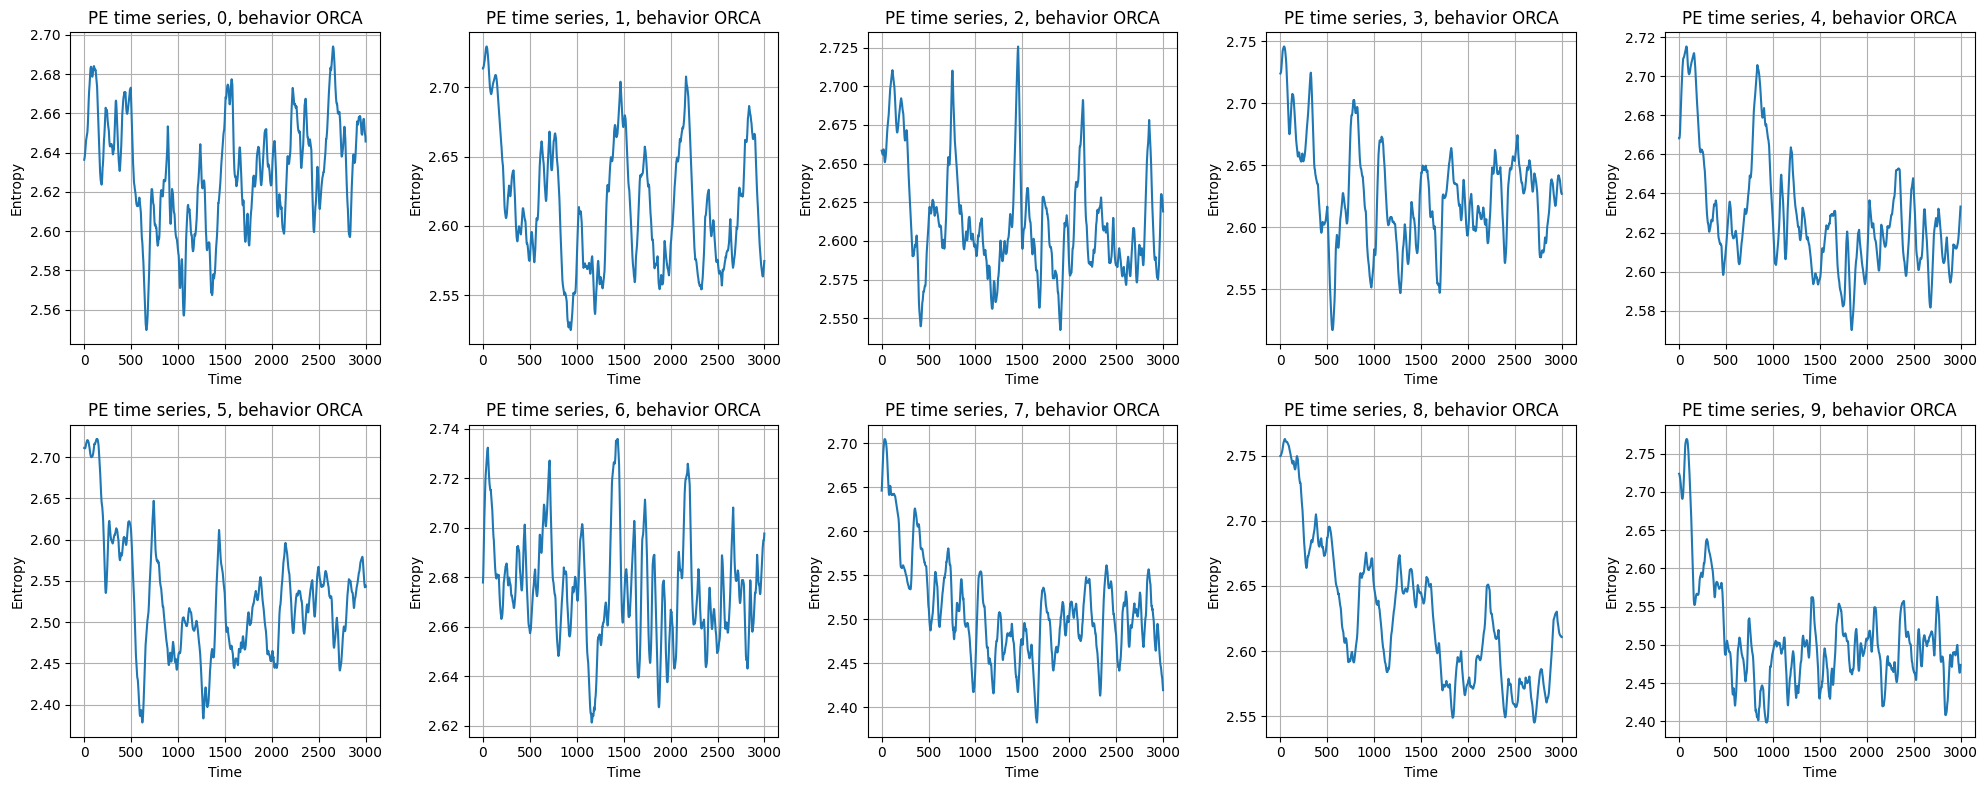

In [5]:
dfHL['persistentEntropy'] = None
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i in tqdm(range(simulations)):
    run = experimentHL.runs[i]
    ps = run.poses
    maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]
    entropies=[]
    for j in range(time_instances):
        persistence = fu.ComputePersistenceDiagram(ps,j,0,"rips")
        persistenceL = fu.limitingDiagram(persistence,maxd[j])
        entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
    dfHL.at[i, 'persistentEntropy'] = np.array(entropies)

    plt.sca(axes[i])
    fu.plotEntropyTimeSerie(entropies)
    plt.title(f'PE time series, {i}, behavior ORCA')
plt.tight_layout()
plt.show()

Now, for the ORCA behavior

In [6]:
yaml = f"""
steps: {time_instances}
time_step: {time_step}
runs: {simulations}
record_pose: true
record_twist: true
record_colllisions: true
record_deadlocks: true
scenario:
    type: Cross
    agent_margin: 0.1
    side: {sideLength}
    target_margin: 0.5
    tolerance: 0.25
    groups:
      -
        type: thymio 
        number: {robots}
        radius: {radioRobot}
        control_period: 0.1
        speed_tolerance: 0.02
        kinematics:
          type: 2WDiff
          wheel_axis: 0.094
          max_speed: 0.166
        behavior:
          type: ORCA
          safety_margin: 
            sampler: uniform
            from: 0.0
            to: 0.5
            once: true
        state_estimation:
          type: Bounded
          range: {radioVision}
"""

experimentORCA = sim.load_experiment(yaml)
wORCA = sim.World()
experimentORCA.scenario.init_world(wORCA,seed=1)
experimentORCA.run()

In [7]:
dfORCA = extract_data(experimentORCA)
dfORCA

,seeds,safety_margin,deadlocks,collisions,safe,fluid,ok
0,0,0.274407,0,0,1,1,1
1,1,0.208511,0,0,1,1,1
2,2,0.217997,0,0,1,1,1
3,3,0.275399,0,0,1,1,1
4,4,0.483515,0,0,1,1,1
5,5,0.110997,0,0,1,1,1
6,6,0.446430,0,0,1,1,1
7,7,0.038154,0,0,1,1,1
8,8,0.436715,0,0,1,1,1
9,9,0.005187,0,0,1,1,1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [32:01<00:00, 192.16s/it]


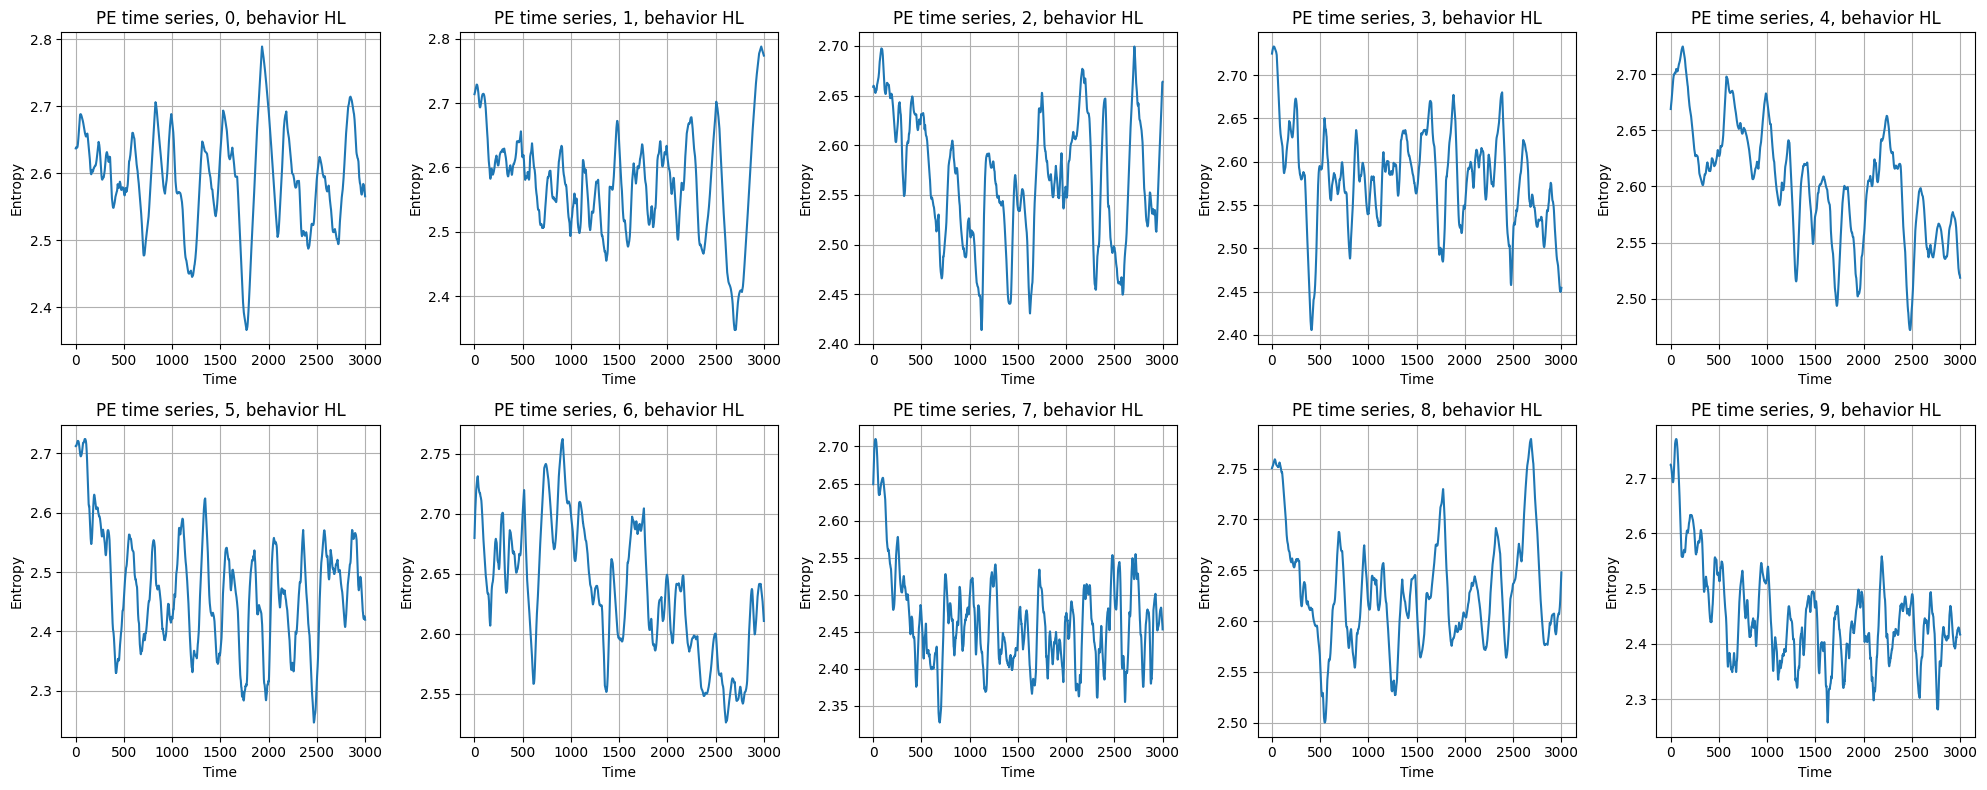

In [8]:
dfORCA['persistentEntropy'] = None
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i in tqdm(range(simulations)):
    run = experimentORCA.runs[i]
    ps = run.poses
    maxd = [float(np.max(distance_matrix(X,X))) for X in ps[:,:,:2]]
    entropies=[]
    for j in range(time_instances):
        persistence = fu.ComputePersistenceDiagram(ps,j,0,"rips")
        persistenceL = fu.limitingDiagram(persistence,maxd[j])
        entropies.append(fu.EntropyCalculationFromBarcode(persistenceL))
    dfORCA.at[i, 'persistentEntropy'] = np.array(entropies)

    plt.sca(axes[i])
    fu.plotEntropyTimeSerie(entropies)
    plt.title(f'PE time series, {i}, behavior HL')
plt.tight_layout()
plt.show()